In [1]:
# 구글드라이브에 Mask2Former폴더 생성 후 코드파일 똑같이 복붙 후 진행. 공유문서함의 dataset 다운받아서 사용.(zip으로 압축해서 구글드라이브에 올림)

# 1. 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 2. 필수 라이브러리 설치
print("Installing dependencies...")

# fvcore (Detectron2의 핵심 라이브러리)
!pip install fvcore

# timm, einops (Swin-Transformer 백본 및 텐서 조작용)
!pip install timm einops

# scipy (matcher.py 및 criterion.py에서 필요)
!pip install scipy

# Detectron2 설치 (코랩에서는 이 방식이 가장 안정적입니다)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

print("✅ All dependencies installed.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Installing dependencies...
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-1nvadhq8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-1nvadhq8
  Resolved https://github.com/facebookresearch/detectron2.git to commit 525208d9d6b36c72500183470fd181848b822468
  Preparing metadata (setup.py) ... done
✅ All dependencies installed.


In [2]:
import sys
import os

# 1. Python이 'Mask2Former' 패키지를 찾을 수 있도록 경로 추가
PROJECT_PARENT_PATH = '/content/drive/MyDrive/Colab Notebooks'
if PROJECT_PARENT_PATH not in sys.path:
    sys.path.append(PROJECT_PARENT_PATH)
    print(f"Added '{PROJECT_PARENT_PATH}' to sys.path")

# 2. 데이터셋 경로 정의
DATASET_ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/Mask2Former/final_dataset_per_file.zip"
LOCAL_DATA_PATH = "/content/data/" # 코랩 로컬 디스크 (빠름)
UNZIPPED_DATA_PATH = os.path.join(LOCAL_DATA_PATH, "final_dataset_per_file") # 압축 해제 후 최종 경로

# 3. 데이터셋 복사 및 압축 해제
if os.path.exists(UNZIPPED_DATA_PATH):
    print(f"✅ Dataset already unzipped at '{UNZIPPED_DATA_PATH}'")
else:
    print(f"Copying dataset from Drive... (takes a few minutes)")
    !cp "{DATASET_ZIP_PATH}" "/content/dataset.zip"
    print("Copy complete. Unzipping...")

    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)
    !unzip -q "/content/dataset.zip" -d "{LOCAL_DATA_PATH}"
    print(f"✅ Dataset unzipped to '{UNZIPPED_DATA_PATH}'")

Added '/content/drive/MyDrive/Colab Notebooks' to sys.path
✅ Dataset already unzipped at '/content/data/final_dataset_per_file'


In [3]:
# [셀 3 수정본]
from fvcore.common.config import CfgNode as _CfgNode
# from helper.helper import ShapeSpec # <--- [수정됨] 이 라인 삭제
from Mask2Former.helper.helper import ShapeSpec # <--- [수정됨] 'Mask2Former'부터 시작

# --- 1. 학습 파라미터 정의 ---
NUM_CLASSES = 1
NUM_QUERIES = 100
DEC_LAYERS = 3
ENC_LAYERS = 3

BATCH_SIZE = 1
EPOCHS = 20
LEARNING_RATE = 5.0e-5
# ---

# --- 2. 모델 초기화용 Input Shape 정의 ---
input_shape = ShapeSpec(channels=3)

# --- 3. [Ground Truth] 백본(Swin) 설정 (smoke_test.py 기반) ---
backbone_cfg = _CfgNode()
backbone_cfg.MODEL = _CfgNode()
backbone_cfg.MODEL.SWIN = _CfgNode()
backbone_cfg.MODEL.SWIN.PRETRAIN_IMG_SIZE = 224
backbone_cfg.MODEL.SWIN.PATCH_SIZE = 4
backbone_cfg.MODEL.SWIN.EMBED_DIM = 96
backbone_cfg.MODEL.SWIN.DEPTHS = [2, 2, 6, 2]
backbone_cfg.MODEL.SWIN.NUM_HEADS = [3, 6, 12, 24]
backbone_cfg.MODEL.SWIN.WINDOW_SIZE = 7
backbone_cfg.MODEL.SWIN.MLP_RATIO = 4.0
backbone_cfg.MODEL.SWIN.QKV_BIAS = True
backbone_cfg.MODEL.SWIN.QK_SCALE = None
backbone_cfg.MODEL.SWIN.DROP_RATE = 0.0
backbone_cfg.MODEL.SWIN.ATTN_DROP_RATE = 0.0
backbone_cfg.MODEL.SWIN.DROP_PATH_RATE = 0.3
backbone_cfg.MODEL.SWIN.APE = False
backbone_cfg.MODEL.SWIN.PATCH_NORM = True
backbone_cfg.MODEL.SWIN.USE_CHECKPOINT = False
backbone_cfg.MODEL.SWIN.OUT_INDICES = (0, 1, 2, 3)
backbone_cfg.MODEL.SWIN.OUT_FEATURES = ["res2", "res3", "res4", "res5"]

# --- 4. [Ground Truth] 픽셀 디코더 설정 (smoke_test.py 기반) ---
pixel_decoder_cfg = _CfgNode()
pixel_decoder_cfg.MODEL = _CfgNode()
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD = _CfgNode()
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD.IN_FEATURES = ["res2", "res3", "res4", "res5"]
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD.CONVS_DIM = 256
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD.MASK_DIM = 256
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD.NORM = "GN"
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD.TRANSFORMER_ENC_LAYERS = ENC_LAYERS
pixel_decoder_cfg.MODEL.MASK_FORMER = _CfgNode()
pixel_decoder_cfg.MODEL.MASK_FORMER.DROPOUT = 0.1
pixel_decoder_cfg.MODEL.MASK_FORMER.NHEADS = 8
pixel_decoder_cfg.MODEL.MASK_FORMER.DIM_FEEDFORWARD = 1024
pixel_decoder_cfg.MODEL.MASK_FORMER.PRE_NORM = False
pixel_decoder_cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = NUM_CLASSES

# --- 5. [Ground Truth] 트랜스포머 디코더 설정 (smoke_test.py 기반) ---
transformer_decoder_cfg = _CfgNode()
transformer_decoder_cfg.MODEL = _CfgNode()
transformer_decoder_cfg.MODEL.MASK_FORMER = _CfgNode()
transformer_decoder_cfg.MODEL.MASK_FORMER.NHEADS = 8
transformer_decoder_cfg.MODEL.MASK_FORMER.DIM_FEEDFORWARD = 2048
transformer_decoder_cfg.MODEL.MASK_FORMER.DEC_LAYERS = DEC_LAYERS
transformer_decoder_cfg.MODEL.MASK_FORMER.DROPOUT = 0.0
transformer_decoder_cfg.MODEL.MASK_FORMER.NUM_OBJECT_QUERIES = NUM_QUERIES
transformer_decoder_cfg.MODEL.SEM_SEG_HEAD = _CfgNode()
transformer_decoder_cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = NUM_CLASSES

print("✅ All 3 config objects (backbone_cfg, pixel_decoder_cfg, transformer_decoder_cfg) created.")

✅ All 3 config objects (backbone_cfg, pixel_decoder_cfg, transformer_decoder_cfg) created.


In [4]:
import torch
import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import os
import numpy as np

class FinalInstanceDataset(Dataset):
    """
    .pt 파일에서 {'instance_class': 텐서, 'mask_paths': [경로1, 경로2...]} 를 읽고,
    'mask_paths'를 이용해 'labels_png/' 폴더에서 실제 마스크(.png)를 로드하는 클래스.
    """
    def __init__(self, image_dir, label_dict_dir, label_png_dir, transform=None):
        self.image_dir = image_dir
        self.label_dict_dir = label_dict_dir
        self.label_png_dir = label_png_dir # 실제 PNG 마스크가 있는 폴더
        self.transform = transform

        self.image_paths = sorted(glob.glob(os.path.join(self.image_dir, "*.png")))
        print(f"Found {len(self.image_paths)} images in {image_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 1. 이미지 불러오기
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        img_w, img_h = image.size

        # 2. ".pt" 라벨 파일 경로 생성 및 로드
        tile_prefix = os.path.basename(image_path).replace(".png", "")
        label_path = os.path.join(self.label_dict_dir, f"{tile_prefix}.pt")

        try:
            target_info = torch.load(label_path)
        except FileNotFoundError:
            print(f"Warning: Label .pt file not found for {image_path}.")
            target_info = {'instance_class': torch.empty((0,), dtype=torch.long), 'mask_paths': []}

        # 3. 'mask_paths' 리스트를 기반으로 실제 .png 마스크 로드
        masks = []
        mask_path_list = target_info.get('mask_paths', [])

        if len(mask_path_list) > 0:
            for mask_filename in mask_path_list:
                full_mask_path = os.path.join(self.label_png_dir, os.path.basename(mask_filename))

                try:
                    mask = Image.open(full_mask_path).convert("L")
                    masks.append(np.array(mask))
                except FileNotFoundError:
                    print(f"Warning: Mask file not found: {full_mask_path}")
                    masks.append(np.zeros((img_h, img_w), dtype=np.uint8))

            masks_np = np.stack(masks, axis=0)
            masks_np = (masks_np > 128).astype(np.uint8) # 0/1 값으로 변환
            mask_tensor = torch.from_numpy(masks_np)

        else:
            mask_tensor = torch.empty((0, img_h, img_w), dtype=torch.uint8)

        # 4. matcher.py가 기대하는 'mask' (단수형) 키로 최종 딕셔너리 생성
        final_target = {
            'mask': mask_tensor,
            'instance_class': target_info['instance_class']
        }

        # 5. 이미지 변환 적용 (OOM 방지를 위해 Resize 추가)
        if self.transform:
            # (주의) Transform은 이미지와 타겟 모두에 적용되어야 하지만,
            # 간단한 T.Compose는 딕셔너리 타겟을 처리 못함.
            # 여기서는 이미지만 변환합니다.
            image = self.transform(image)

            # (중요) 이미지 크기가 바뀌면 마스크 크기도 바꿔야 함!
            # T.Resize는 PIL 이미지만 받으므로 텐서를 다시 PIL로 변환 후 리사이즈
            final_target['mask'] = T.functional.resize(
                final_target['mask'],
                image.shape[1:], # (H, W) - 텐서의 크기 (C, H, W)
                interpolation=T.InterpolationMode.NEAREST
            )

        return image, final_target

def training_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images_tensor = torch.stack(images)
    return images_tensor, targets

print("✅ Final Dataset (using .pt + .png) and Collate Function defined.")

✅ Final Dataset (using .pt + .png) and Collate Function defined.


In [5]:
# [셀 5 최종 수정본 - 2개의 버그 모두 패치]

CRITERION_PATH = "/content/drive/MyDrive/Colab Notebooks/Mask2Former/matcher_criterion/criterion.py"

# --- Patch 1: (이전 오류) cross_entropy 인자 수정 ---
OLD_LINE_1 = "class_loss = F.cross_entropy(predicted_class.reshape(B*Q, 2), target_class, self.background_ratio, self.background_ratio.to(predicted_class.device))"
NEW_LINE_1 = "class_loss = F.cross_entropy(predicted_class.reshape(B*Q, 2), target_class, weight=self.background_ratio.to(predicted_class.device))"

# --- Patch 2: (현재 오류) index_select 디바이스 불일치 수정 ---
# (t_idx를 target_mask와 같은 디바이스로 이동시킴)
OLD_LINE_2 = "target_mask = torch.index_select(target_mask, dim=0, index=t_idx).unsqueeze(1)"
NEW_LINE_2 = "target_mask = torch.index_select(target_mask, dim=0, index=t_idx.to(target_mask.device)).unsqueeze(1)"

try:
    # 파일 읽기
    with open(CRITERION_PATH, 'r') as f:
        content = f.read()

    patched = False

    # 패치 1 적용
    if OLD_LINE_1 in content:
        content = content.replace(OLD_LINE_1, NEW_LINE_1)
        print("✅ Patch 1 (cross_entropy bug) applied.")
        patched = True
    else:
        print("✅ Patch 1 (cross_entropy bug) already applied or not needed.")

    # 패치 2 적용
    if OLD_LINE_2 in content:
        content = content.replace(OLD_LINE_2, NEW_LINE_2)
        print("✅ Patch 2 (device mismatch bug) applied.")
        patched = True
    else:
        print("✅ Patch 2 (device mismatch bug) already applied or not needed.")

    # 수정된 내용으로 파일 다시 쓰기
    if patched:
        with open(CRITERION_PATH, 'w') as f:
            f.write(content)
        print("--- 'criterion.py' file patching complete. ---")

except Exception as e:
    print(f"❌ Error patching file: {e}")

✅ Patch 1 (cross_entropy bug) already applied or not needed.
✅ Patch 2 (device mismatch bug) already applied or not needed.


In [6]:
import torch
from torch.optim import AdamW
import torchvision.transforms as T
import time
import os

# --- 프로젝트 모듈 임포트 ---
from Mask2Former.make_mask2former_model import Mask2Former
from Mask2Former.matcher_criterion.criterion import criterion

# --- 0. 학습 환경 설정 ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. 데이터 로더 준비 ---
LOCAL_IMG_DIR = os.path.join(UNZIPPED_DATA_PATH, "images")
LOCAL_LABEL_DICT_DIR = os.path.join(UNZIPPED_DATA_PATH, "labels_dict")
LOCAL_LABEL_PNG_DIR = os.path.join(UNZIPPED_DATA_PATH, "labels_png")

# (OOM 방지를 위해 512x512로 리사이즈)
train_transform = T.Compose([
    T.Resize((512, 512)), # <--- 이미지 크기 조절
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = FinalInstanceDataset(
    image_dir=LOCAL_IMG_DIR,
    label_dict_dir=LOCAL_LABEL_DICT_DIR,
    label_png_dir=LOCAL_LABEL_PNG_DIR,
    transform=train_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE, # (셀 3에서 1로 설정됨)
    shuffle=True,
    collate_fn=training_collate_fn,
    num_workers=2
)

print(f"DataLoader created with {len(train_loader)} batches (Batch Size={BATCH_SIZE}).")

# --- 2. 모델 빌드 (가장 중요한 수정) ---
# [셀 3]에서 만든 3개의 개별 cfg 객체를 전달합니다.
model = Mask2Former(
    backbone_cfg=backbone_cfg,
    pixel_decoder_cfg=pixel_decoder_cfg,
    transformer_decoder_cfg=transformer_decoder_cfg,
    input_shape=input_shape
)
model.to(DEVICE)
print("Model loaded to device.")

# --- 3. 손실 함수(Criterion) 빌드 ---
criterion = criterion(
    oversample_ratio=3.0,
    important_sample_ratio=0.75,
    class_cost_weight=2.0,
    mask_cost_weight=5.0,
    dice_cost_weight=5.0,
    eos_weigt=0.1
)
criterion.to(DEVICE)
print("Criterion (loss function) created.")

# (Loss 가중치 딕셔너리)
weight_dict = {
    "class_loss": 1.0,
    "mask_loss": 5.0,
    "dice_loss": 5.0
}

# (Auxiliary losses - [셀 3]의 DEC_LAYERS 값(3)에 따라 동적으로 생성)
dec_layers = transformer_decoder_cfg.MODEL.MASK_FORMER.DEC_LAYERS
if dec_layers > 1:
    aux_weight_dict = {}
    for i in range(dec_layers - 1):
        aux_weight_dict.update({k + f"_{i}": v for k, v in weight_dict.items()})
    weight_dict.update(aux_weight_dict)

# --- 4. 옵티마이저(Optimizer) 빌드 ---
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.05)
print("Optimizer created.")

# --- 5. 🔥 학습 루프(Training Loop) 시작 ---
print(f"--- Starting Training for {EPOCHS} Epochs ---")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    for i, (images, targets) in enumerate(train_loader):

        # 1. 데이터를 DEVICE (GPU)로 이동
        images = images.to(DEVICE)
        targets = [
            {k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v
             for k, v in t.items()}
            for t in targets
        ]

        # 2. Forward pass (모델 예측)
        outputs = model(images)

        # 3. Loss 계산 (버그 패치된 criterion 사용)
        loss_dict = criterion(outputs, targets)

        # (weight_dict 키 이름을 criterion.py의 출력에 맞춤)
        final_weight_dict = {
            "class_loss": weight_dict.get("loss_ce", 1.0), # (이전 오류 수정 반영 - "loss_ce" 대신 "class_loss" 사용)
            "mask_loss": weight_dict.get("loss_mask", 5.0),
            "dice_loss": weight_dict.get("loss_dice", 5.0)
        }
        if dec_layers > 1:
            for i in range(dec_layers - 1):
                final_weight_dict.update({
                    f"class_loss_{i}": weight_dict.get(f"loss_ce_{i}", 1.0),
                    f"mask_loss_{i}": weight_dict.get(f"loss_mask_{i}", 5.0),
                    f"dice_loss_{i}": weight_dict.get(f"loss_dice_{i}", 5.0)
                })

        loss = sum(loss_dict[k] * final_weight_dict[k] for k in loss_dict.keys() if k in final_weight_dict)

        # 4. Backward pass (가중치 업데이트)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # 20 배치마다 로그 출력 (배치 80개 기준)
        if (i + 1) % 20 == 0:
            print(f"  [Epoch {epoch+1}/{EPOCHS}, Batch {i+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    end_time = time.time()
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"--- Epoch {epoch+1} Complete --- Avg Loss: {avg_epoch_loss:.4f} --- Time: {end_time - start_time:.2f}s ---")

print("🎉 --- Training Finished --- 🎉")

Using device: cuda
Found 80 images in /content/data/final_dataset_per_file/images
DataLoader created with 80 batches (Batch Size=1).


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model loaded to device.
Criterion (loss function) created.
Optimizer created.
--- Starting Training for 20 Epochs ---


/content/drive/MyDrive/Colab Notebooks/Mask2Former/matcher_criterion/matcher.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


--- Epoch 1 Complete --- Avg Loss: 14.4563 --- Time: 88.54s ---
--- Epoch 2 Complete --- Avg Loss: 13.3750 --- Time: 86.65s ---
--- Epoch 3 Complete --- Avg Loss: 13.2864 --- Time: 83.64s ---
--- Epoch 4 Complete --- Avg Loss: 13.3481 --- Time: 85.01s ---
--- Epoch 5 Complete --- Avg Loss: 13.2168 --- Time: 85.20s ---
--- Epoch 6 Complete --- Avg Loss: 13.1588 --- Time: 84.79s ---
--- Epoch 7 Complete --- Avg Loss: 13.1396 --- Time: 85.72s ---
--- Epoch 8 Complete --- Avg Loss: 13.0724 --- Time: 86.07s ---
--- Epoch 9 Complete --- Avg Loss: 12.9614 --- Time: 86.68s ---
--- Epoch 10 Complete --- Avg Loss: 12.9673 --- Time: 85.96s ---
--- Epoch 11 Complete --- Avg Loss: 13.0633 --- Time: 86.07s ---
--- Epoch 12 Complete --- Avg Loss: 13.0401 --- Time: 87.19s ---
--- Epoch 13 Complete --- Avg Loss: 13.0081 --- Time: 86.31s ---
--- Epoch 14 Complete --- Avg Loss: 12.9982 --- Time: 85.42s ---
--- Epoch 15 Complete --- Avg Loss: 13.0368 --- Time: 82.02s ---
--- Epoch 16 Complete --- Avg Loss

Using device: cuda
Found 80 images in /content/data/final_dataset_per_file/images
Loading image at index 5...
Running model inference...
✅ Inference and post-processing complete.
Displaying results...


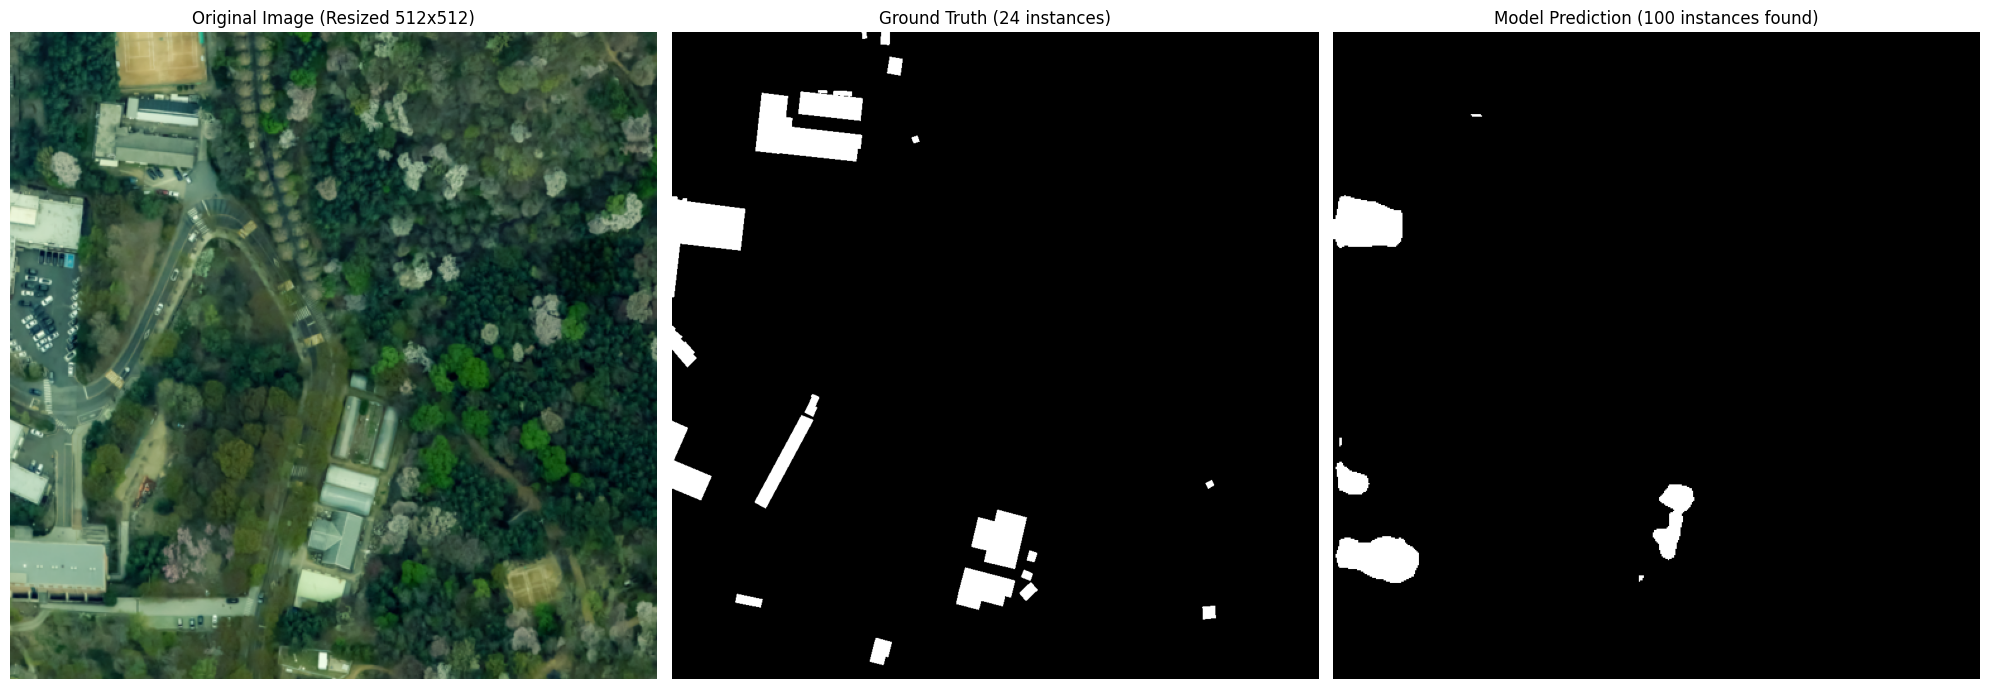

In [7]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 시각화할 이미지 선택 ---
IMAGE_INDEX = 5 # (0 ~ 79 사이의 숫자로 바꿔서 테스트해보세요)

# --- 2. 환경 설정 ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 3. 데이터 로딩 ---
# (OOM 방지를 위해 512x512로 리사이즈했던 것을 동일하게 적용)
# 모델에 입력할 '정규화된' 텐서
inference_transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 화면에 표시할 '원본' PIL 이미지 (리사이즈만 적용)
display_transform = T.Compose([
    T.Resize((512, 512)),
])

# (셀 4에서 정의한 FinalInstanceDataset 클래스 사용)
vis_dataset = FinalInstanceDataset(
    image_dir=LOCAL_IMG_DIR,
    label_dict_dir=LOCAL_LABEL_DICT_DIR,
    label_png_dir=LOCAL_LABEL_PNG_DIR,
    transform=None # <--- transform은 수동으로 따로 적용
)

print(f"Loading image at index {IMAGE_INDEX}...")
# 원본 PIL 이미지와 딕셔너리 로드
original_pil_image, target_dict = vis_dataset[IMAGE_INDEX]

# 원본 이미지를 화면 표시용으로 리사이즈
display_image = display_transform(original_pil_image)

# 원본 이미지를 모델 입력용으로 변환
input_tensor = inference_transform(original_pil_image)

# --- 4. 모델 추론 (Inference) ---
print("Running model inference...")
model.eval() # 모델을 추론 모드로 설정
with torch.no_grad(): # 그래디언트 계산 중지
    # [1, C, H, W] 배치 형태로 만들어서 GPU로 보냄
    outputs = model(input_tensor.unsqueeze(0).to(DEVICE))

# --- 5. 후처리 (Post-processing) ---
# 모델의 출력을 CPU로 가져옴
pred_logits = outputs['predicted_class'][0].cpu() # [100, 2] (NumQueries, NumClasses+1)
pred_masks = outputs['predicted_mask'][0].cpu()   # [100, 128, 128] (NumQueries, H/4, W/4)

# 5.1: 마스크를 512x512 크기로 업샘플링
pred_masks_upsampled = F.interpolate(
    pred_masks.unsqueeze(1),
    size=(512, 512), # (train_transform에서 리사이즈한 크기)
    mode="bilinear",
    align_corners=False
).squeeze(1)

# 5.2: 마스크 로짓에 시그모이드(sigmoid)를 적용
pred_masks_sigmoid = pred_masks_upsampled.sigmoid() # [100, 512, 512]

# 5.3: 클래스 예측 점수 계산 (0번 클래스가 '건물'이라고 가정)
probs = pred_logits.softmax(-1)
scores = probs[:, 0] # '건물' 클래스에 대한 점수 [100]

# 5.4: 점수가 0.5 이상인 것만 필터링
SCORE_THRESH = 0.5
keep = scores > SCORE_THRESH
final_masks = pred_masks_sigmoid[keep]
final_masks_binary = (final_masks > 0.5) # 0 또는 1 값으로 변환

# 5.5: 예측된 마스크들을 하나로 합치기
if final_masks_binary.shape[0] > 0:
    combined_prediction_mask = torch.any(final_masks_binary, dim=0).float()
else:
    # 아무것도 예측하지 못한 경우
    combined_prediction_mask = torch.zeros((512, 512), dtype=torch.float32)

# 5.6: 실제 정답(Ground Truth) 마스크 합치기
gt_masks = target_dict['mask']
# (Dataset 클래스가 이미 512x512로 리사이즈 해줌 - 셀 4 코드 수정 참고)
# [N, 512, 512] -> [512, 512]
if gt_masks.shape[0] > 0:
    combined_gt_mask = torch.any(gt_masks, dim=0).float()
else:
    combined_gt_mask = torch.zeros((512, 512), dtype=torch.float32)

print("✅ Inference and post-processing complete.")

# --- 6. 시각화 ---
print("Displaying results...")
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# 1. 원본 이미지
axes[0].imshow(display_image)
axes[0].set_title("Original Image (Resized 512x512)")
axes[0].axis('off')

# 2. 실제 정답 (Ground Truth)
axes[1].imshow(combined_gt_mask, cmap='gray')
axes[1].set_title(f"Ground Truth ({gt_masks.shape[0]} instances)")
axes[1].axis('off')

# 3. 모델 예측 (Prediction)
axes[2].imshow(combined_prediction_mask, cmap='gray')
axes[2].set_title(f"Model Prediction ({final_masks_binary.shape[0]} instances found)")
axes[2].axis('off')

plt.tight_layout()
plt.show()